#**Shortest Path Kernel**

Shortest Path Graph Kernels are proposed in the paper [Shortest Path Kernels on Graph](https://www.dbs.ifi.lmu.de/~borgward/papers/BorKri05.pdf)

kernel datasets
https://ls11-www.cs.tu-dortmund.de/staff/morris/graphkerneldatasets



Given a graph $G = (V,E)$ with  $\{ e_{1} , e_{2}  , \dots, e_{l} \} \subset E$ and $\{v_{i_1} , v_{i_2} , v_{j_1} , v_{j_2} \} \subset V$


Floyd Transformation



In [ ]:
#install python-igraph : we use IGraph for manipulating and storing graph data

!pip install python-igraph
!pip install cairocffi

     |████████████████████████████████| 3.2MB 20.7MB/s 
     |████████████████████████████████| 71kB 6.2MB/s 
  Created wheel for cairocffi: filename=cairocffi-1.2.0-cp37-none-any.whl size=89548 sha256=eb98edf6265c6476336259f3e3e6645324d06c3a9768d08736098ab3cc987638
  Stored in directory: /root/.cache/pip/wheels/40/76/48/f1effadceea83b32e7d957dd0f92db4db8b537d7b72b4ef374
Successfully built cairocffi


In [ ]:
import os
import igraph as ig
from collections import Counter
import numpy as np
from IPython.core.display import display, Image
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import johnson
from itertools import combinations

In [ ]:
#mounting the data  on drive 

from google.colab import drive
drive.mount('/content/drive')
path = 'data/graph_data'

Mounted at /content/drive


In [ ]:
#retreving the file names
def get_data(path):
  graph_files = []
  for file in os.listdir(path):
    if file.endswith('gml'):
        graph_files.append(os.path.join(path,file))
  graph_files.sort()
  return graph_files
  

In [ ]:
def read_gml(filename):
  node_features = []
  g = ig.read(filename)
  if not 'label' in g.vs.attribute_names():
    g.vs['label'] = list(map(str,[l for l in g.vs.degree()]))
  node_features = g.vs['label']
  adj_mat  = np.asarray(g.get_adjacency().data)  
  return node_features,adj_mat

In [ ]:
#making sure that multiple igraph plots are shown in single jupyter cell

def plot(G,id):
  print("Graph "+id,end= "\n\n")
  ig.plot(G,bbox = (200, 200)).save('temporary.png') 
  display(Image(filename='temporary.png'))
  os.remove('temporary.png')

Graph G1



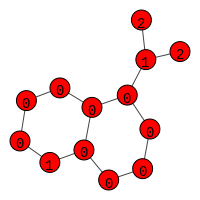

Graph G2



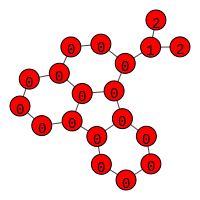

In [ ]:
#sample graph

mutang_path = '/content/drive/MyDrive/data/graph_data/MUTAG'
graph_files = get_data(path)
G0 = ig.read(graph_files[2])
G1 = ig.read(graph_files[3])

plot(G0,"G1")
plot(G1,"G2")

##**Floyd Transformation** 

In [ ]:
#unable to find/understand igraphs's native shortest path algorithm
#so for now will be using scipy's johnson 
def floyd_transformation(g):
  Eg = np.asarray(g.get_adjacency(attribute = "weight").data)
  csr_graph = csr_matrix(Eg)
  dist_matrix = johnson(csgraph=csr_graph, directed=False)
  floyd_graph = ig.Graph()

  for v in g.vs :
    floyd_graph.add_vertex(id=v['id'], label =v['label'])

  for i,j in combinations(range(g.vcount()),2):
    if dist_matrix[i,j] !=0 :
      floyd_graph.add_edge(i,j,weight=dist_matrix[i,j])

  return floyd_graph    


Graph floyd 





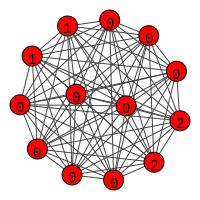

Graph floyd 





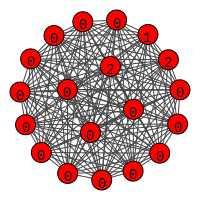

In [ ]:

floyd_graph_g1 = floyd_transformation(G0)
floyd_graph_g2 = floyd_transformation(G1)

plot(floyd_graph_g1,"floyd \n\n")
plot(floyd_graph_g2,"floyd \n\n")

##**Shortest Path Kernels**

shortest path graph kernel : Let $G_1$ and $G_2$ be two graphs that are floyd-transformed into $S_1$ and $S_2$. We can then define our shortest path graph kernel on $S_1 = (V_1,E_1)$ and $S_2 = (V_2,E_2)$ as 

$$k_{\text{shortest paths}}(S_1,S_2) = \sum_{e_1 \in E_1} \sum_{e_2 \in E_2} k_{\text{walk}}^{(1)}(e_1,e_2)$$

where $k_{\text{walk}}^{1}$ is a positive definite kernel on edge walks of lenght $1$

In [ ]:
#kernel on edges walks of length 1

def kernel_on_edges(edge1, edge2):



In [ ]:
# returns shortest_path_kernel between pair of graphs 

def shortest_path_kernel(g1,g2):
  
  K = 0
  fg_g1 = floyd_transformation(g1)
  fg_g2 = floyd_transformation(g2)

  for e1 in fg_g1.es :
    for e2 in fg_g2.es:
      K += kernel_on_edges(e1,e2)
  return K   

In [ ]:
# computes the kernel matrix and 

def kernel_mat(graphs,K):
  N_gs = len(graphs)
  Kernel = np.zeros((N_gs , N_gs))
  for i,j in tqdm(combinations_with_replacement(range(N_gs),2)):
    Kernel[i][j] = Kernel[j][i] = K(graphs[i], graphs[j])

  return Kernel  

In [ ]:
# Does StratifiedKFold split and returns Avg Accuracy score

def use_k_fold(Kernel,labels,n_splits):

  skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
  acc_scores = list()
  for train_idx,test_idx in skf.split(Kernel,labels):
    
    Kernel_train = Kernel[train_idx][:, train_idx]
    Kernel_test  = Kernel[test_idx][:,train_idx]
    y_train = labels[train_idx]
    y_test  = labels[test_idx]
    fold_score = graph_classification(Kernel_train,Kernel_test,y_train,y_test)
    acc_scores.append(fold_score)

  avg_acc_score = np.mean(acc_scores)
  return avg_acc_score  


In [ ]:
label_file = os.path.join(mutang_path, 'Labels.txt')
labels = np.loadtxt(label_file)

In [ ]:
print(len(Gs))
Kernel = kernel_mat(Gs)

In [ ]:
n_splits = 5
avg_acc_score = use_k_fold(Kernel,labels,n_splits)
print("classification accuracy :" , avg_acc_score)